In [1]:
import json
import os
import cv2
from pathlib import Path
from PIL import Image, ImageOps
import pandas as pd
from pandas import json_normalize
import random
import re
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import models
from torchvision.models import resnet50
from torchvision.io import read_image
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

# Load the SDK
import lyft_dataset_sdk
from lyft_dataset_sdk.lyftdataset import LyftDataset, LyftDatasetExplorer, Quaternion, view_points
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud
from lyft_dataset_sdk.utils.geometry_utils import BoxVisibility, box_in_image, view_points

In [2]:
data_path = Path(r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles")
json_path = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\data"
lyftdata = LyftDataset(data_path=data_path, json_path=json_path, verbose=True)

9 category,
18 attribute,
4 visibility,
18421 instance,
10 sensor,
148 calibrated_sensor,
177789 ego_pose,
180 log,
180 scene,
22680 sample,
189504 sample_data,
638179 sample_annotation,
1 map,
Done loading in 9.9 seconds.
Reverse indexing ...
Done reverse indexing in 2.6 seconds.


## Data Selection/Preprocessing

In [20]:
lyftdata.sample_annotation

[{'token': '92bff46db1dbfc9679edc8091770c4256ac3c027e9f0a9c31dfc4fff41f6f677',
  'num_lidar_pts': -1,
  'size': [2.064, 5.488, 2.053],
  'sample_token': 'db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce76edd4af4d04e49341',
  'rotation': [0.265491936795379, 0, 0, 0.964113080243515],
  'prev': 'db2c5aea69d8be40a746c5f3df9366e030189b07647212f338b31240c15896df',
  'translation': [2680.2830359778527, 698.1969292852777, -18.04776692365821],
  'num_radar_pts': 0,
  'attribute_tokens': ['1ba8c9a8bda54423fa710b0af1441d849ecca8ed7b7f9393ba1794afe4aa6aa2',
   'daf16a3f6499553cc5e1df4a456de5ee46e2e6b06544686d918dfb1ddb088f6f'],
  'next': '33e07b849d62718279c9548fe662d32247e319f0451cd461059305c3e42dcea0',
  'instance_token': 'abea2eb040d9c8fa1a44fa54020daaf9e2aa696e95e1d257481ecbf6e13a318c',
  'visibility_token': '',
  'category_name': 'car'},
 {'token': '04c4c9883de582c5c4e7a45273a978a52b0432de18883f60e7dd0e5cd2137628',
  'num_lidar_pts': -1,
  'size': [1.635, 4.339, 1.515],
  'sample_token': 'edf37

In [35]:
#In order to find the image files that contain our pedestrian_anns, we must do the following:
#Accumulate the superset of Samples that contain all of our pedestrian_annotations
def img_class_selector(class_name, forced_anno_data_path, box_visibility = BoxVisibility.ALL):
    """
    There wasn't a super clean way in the API to select image files that contain annotations from x class. I adapted the method they use in their .render_annotation() method.

    Returns tuples of (file_path, Box object, camera_intrinsic, sample_token, cam)
    """

    #Lyft SDK expects a certain directory structure. Since we have Test data broken out into separate dir, if we want our test data, we can't call it from lyftdata object. Instead, call directly.
    if not forced_data_path:
        annos_class = lyftdata.sample_annotation
    else:
        with open(str(forced_data_path)) as f:
            annos_class = json.load(f)

    #Filter all annotations down to only annotations our our class of interest.
    class_anns = [d for d in annos_class if d["category_name"] == class_name]
    sample_class_tokens = set()
    for ann in class_anns:
        sample_class_tokens.add(ann["sample_token"])

    class_images_boxes = []
    for sample_token in sample_class_tokens:
        sample_record = lyftdata.get("sample", sample_token)
        sample_anns = sample_record["anns"]
        cams = [key for key in sample_record["data"].keys() if "CAM" in key]
        
        #We unfortunately do have to iterate through each annotation that exists within the sample_record. There typically aren't more than 20-30 or so.
        for ann in sample_anns:
            # Figure out which camera the object is fully visible in (this may return nothing)
            for cam in cams:
                path, box, camera_intrinsic = lyftdata.get_sample_data(sample_record["data"][cam], box_vis_level=box_visibility, selected_anntokens=[ann])
                if box:
                    if box[0].name == class_name:
                        class_images_boxes.append((str(path), box[0], camera_intrinsic, sample_token, cam, ann))

    return class_images_boxes

In [4]:
def crop_select_images(img_class_selector_output, output_path, output_size ,box_area_threshold = 5000):
    path, box, camera_intrinsic, sample_token, cam, ann = img_class_selector_output
    
    box_coords = view_points(box.corners(), view = camera_intrinsic, normalize=True)[:2, :]
    
    # Calculate bounding box coordinates
    x_min = np.min(box_coords[0])
    y_min = np.min(box_coords[1])
    x_max = np.max(box_coords[0])
    y_max = np.max(box_coords[1])

    # Calculate the area of the bounding box
    box_area = (x_max - x_min) * (y_max - y_min)

    if box_area > box_area_threshold:
        img = Image.open(path)
        match = re.search(r'images\\(.+)', path)

        if match:
            file_name = match.group(1)
        else:
            print("Pattern not found in the path", path)
            pass

        # Crop the image. This is our initial cropping from the full size image. It is with respect to the bounding box size using box_area_threshold.
        # Pillow uses a system of (left, upper, right, lower)
        img_cropped = img.crop((x_min, y_min, x_max, y_max))

        # Check if the directory exists, if not, create it
        Path(output_path).mkdir(parents=True, exist_ok=True)
        #Save the image
        img_cropped.save(os.path.join(output_path, "cropped_" + file_name[:-5] + "_" + ann + file_name[-5:]))

In [5]:
categories = [lyftdata.category[i]["name"] for i in range(len(lyftdata.category))]
categories

['car',
 'pedestrian',
 'animal',
 'other_vehicle',
 'bus',
 'motorcycle',
 'truck',
 'emergency_vehicle',
 'bicycle']

In [6]:
# ped_images_boxes = img_class_selector("pedestrian")
# crop_select_images(ped_images_boxes)

# categories = [lyftdata.category[i]["name"] for i in range(len(lyftdata.category))]
# for cat in categories:

#     #We can skip car because we know we aren't doing this one, plus its by far the largest and most timely.
#     if cat != "car":
#         #Obtain all of the annotations and their corresponding data via image_class_selector
#         cat_images_boxes = img_class_selector(cat)

#         #Do the actual cropping and write cropped images to disk
#         img_output_path = os.path.join(r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\images", cat +"_cropped")
        
#         for i in range(len(cat_images_boxes)):
#             crop_select_images(cat_images_boxes[i], output_path=img_output_path, box_area_threshold=5000)

## Preprocess pedestrain images with additional processes like Padding and Center cropping for input into model

In [7]:
def dynamic_transform(cropped_images_dir, image_sizes_list):

    for size in image_sizes_list:
        categories = os.listdir(cropped_images_dir)
        for category in categories:
            category_dir = os.path.join(cropped_images_dir, category)
            new_out_dir = os.path.join(cropped_images_dir, category + "_" + str(size))
            if not os.path.exists(new_out_dir):
                os.makedirs(new_out_dir)

            #For each image in the directory "category", modify it such that it is resized to "size".
            for image_file in os.listdir(category_dir):
                img_path = os.path.join(category_dir, image_file)
                img = Image.open(img_path)
                img_width, img_height = img.size

                if img_width < size or img_height < size:
                    # Calculate padding
                    padding_left = (size - img_width) // 2 if img_width < size else 0
                    padding_top = (size - img_height) // 2 if img_height < size else 0

                    # Adjust for odd total padding
                    padding_right = size - img_width - padding_left
                    padding_bottom = size - img_height - padding_top

                    # Apply padding
                    img = ImageOps.expand(img, (padding_left, padding_top, padding_right, padding_bottom), fill=0)

                elif img_width > size or img_height > size:
                    # Crop the image to the required size if it's larger
                    img = transforms.CenterCrop(size)(img)

                # No else case needed, as no action is taken if the image is already the required size
                if img.size != (size, size):
                    #Throw an exception here and break the method. Before breaking, add img_path to self.problem_images
                        # Raise an exception
                    raise RuntimeError(f"Image size after transformation does not match required size of {size} for image and instead is of size {img.size}: {img_path}. Original image size: {img_width} {img_height}")
                
                # Save the transformed image
                img.save(os.path.join(new_out_dir, image_file))

### Only run the code in the cell below if we haven't yet preprocessed any images or if we need to process them at a new, different size.

In [8]:
# cropped_images_dir = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\images\cropped_images"
# sizes = [224]
# dynamic_transform(cropped_images_dir, sizes)

## Define our custom Dataset class

In [9]:
class Lyft_experimental_CustomDataset(Dataset):
    def __init__(self, cropped_images_dir, target_class_name, required_size=224):
        self.cropped_images_dir = cropped_images_dir
        self.required_size = required_size
        self.image_filenames = os.listdir(cropped_images_dir)
        self.problem_images = []
        self.data = []
        #Our class will ingest cropped images from all classes. We must add corresponding labels to these images.
        #The images are stored in directories wrt their class. So, we use the dir name to label the image.
        # Iterate over each subdirectory in the main directory
        for class_name in os.listdir(cropped_images_dir):
            class_dir = os.path.join(cropped_images_dir, class_name)
            if os.path.isdir(class_dir):  # Check if it's a directory
                is_target_class = class_name == target_class_name
                label = 1 if is_target_class else 0

                for filename in os.listdir(class_dir):
                    file_path = os.path.join(class_dir, filename)
                    if os.path.isfile(file_path):  # Check if it's a file
                        self.data.append((file_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path)

        # Convert the image to tensor and normalize
        image = transforms.ToTensor()(image)
        image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)

        return image, label

In [10]:
cropped_images_dir = r'S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\images\cropped_images\224'
dataset = Lyft_experimental_CustomDataset(cropped_images_dir, target_class_name = "pedestrian", required_size=224)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [11]:
for data in dataloader:
    print(data[0])
    print(data[1])
    # print(data[1][0])
    break

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

In [12]:
for i, data in enumerate(dataloader):
    print(f"Batch {i}: Labels - {data[1]}")
    if i == 5:  # Check first 5 batches
        break

Batch 0: Labels - tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0])
Batch 1: Labels - tensor([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1])
Batch 2: Labels - tensor([0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 1, 1, 0, 1, 0])
Batch 3: Labels - tensor([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0])
Batch 4: Labels - tensor([0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0])
Batch 5: Labels - tensor([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0])


In [13]:
for i in range(10):  # Test the first 10 items
    try:
        print(dataset[i])
    except Exception as e:
        print(f"Error at index {i}: {e}")

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -

## Import Pytorch models and train.

In [89]:
model_res50 = models.resnet50(pretrained=True)
num_ftrs = model_res50.fc.in_features
print(num_ftrs)
model_res50.fc = nn.Linear(num_ftrs, 2) # Modify the last layer for binary classification

2048


#### Define loss function

In [90]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model_res50.parameters(), lr=0.001)

#### Check if GPU is available and move the model to GPU if it is

In [91]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model_res50 = model_res50.to(device)

cuda:0


#### Train through n epochs. In each epoch, we set the model into train mode. 

In [92]:
# # Number of epochs to train for
# num_epochs = 10

# for epoch in range(num_epochs):
#     #Set training mode at beginning of each epoch in case we train on validation data within epoch with requires model.eval()
#     model_res50.train()  # Set the model to training mode

#     running_loss = 0.0
#     running_corrects = 0

#     # Iterate over data
#     for inputs, labels in dataloader:
#         inputs = inputs.to(device)
#         labels = labels.to(device)

#         # Zero the parameter gradients
#         optimizer.zero_grad()

#         # Forward pass
#         outputs = model_res50(inputs)
#         loss = criterion(outputs, labels)

#         # Backward pass and optimize
#         loss.backward()
#         optimizer.step()

#         # Statistics
#         running_loss += loss.item() * inputs.size(0)
#         _, preds = torch.max(outputs, 1)
#         running_corrects += torch.sum(preds == labels.data)

#     epoch_loss = running_loss / len(dataset)
#     epoch_acc = running_corrects.double() / len(dataset)

#     print(f'Epoch {epoch}/{num_epochs - 1} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    # # Assuming you have the final loss and accuracy in variables `final_loss` and `final_acc`
    # final_loss = 0.0303
    # final_acc = 0.9891

    # # Save the model state and metrics in a dictionary
    # checkpoint = {
    #     'model_state_dict': model_res50.state_dict(),
    #     'final_loss': final_loss,
    #     'final_accuracy': final_acc
    # }

    # # Save the checkpoint
    # torch.save(checkpoint, 'model_res50_checkpoint.pth')

    # # To load the model and metrics later
    # checkpoint = torch.load('model_res50_checkpoint.pth')
    # model_res50.load_state_dict(checkpoint['model_state_dict'])
    # loaded_final_loss = checkpoint['final_loss']
    # loaded_final_acc = checkpoint['final_accuracy']

Epoch 0/9 Loss: 0.1191 Acc: 0.9553
Epoch 1/9 Loss: 0.0849 Acc: 0.9677
Epoch 2/9 Loss: 0.0723 Acc: 0.9738
Epoch 3/9 Loss: 0.0673 Acc: 0.9755
Epoch 4/9 Loss: 0.0566 Acc: 0.9786
Epoch 5/9 Loss: 0.0501 Acc: 0.9812
Epoch 6/9 Loss: 0.0440 Acc: 0.9837
Epoch 7/9 Loss: 0.0388 Acc: 0.9862
Epoch 8/9 Loss: 0.0356 Acc: 0.9869
Epoch 9/9 Loss: 0.0303 Acc: 0.9891


In [ ]:
# torch.save(model_res50, r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\models\resnet50_2023_11_19_01_47")

## Load the model we trained back into our Notbook after previously saving it.

In [14]:
model_res50 = torch.load(r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\models\resnet50_2023_11_19_01_47")
model_res50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
for name, layer in model_res50.named_modules():
    if isinstance(layer, nn.Conv2d):
        print(f"Layer: {name} | Kernel Size: {layer.kernel_size} | Output Channels: {layer.out_channels}")

Layer: conv1 | Kernel Size: (7, 7) | Output Channels: 64
Layer: layer1.0.conv1 | Kernel Size: (1, 1) | Output Channels: 64
Layer: layer1.0.conv2 | Kernel Size: (3, 3) | Output Channels: 64
Layer: layer1.0.conv3 | Kernel Size: (1, 1) | Output Channels: 256
Layer: layer1.0.downsample.0 | Kernel Size: (1, 1) | Output Channels: 256
Layer: layer1.1.conv1 | Kernel Size: (1, 1) | Output Channels: 64
Layer: layer1.1.conv2 | Kernel Size: (3, 3) | Output Channels: 64
Layer: layer1.1.conv3 | Kernel Size: (1, 1) | Output Channels: 256
Layer: layer1.2.conv1 | Kernel Size: (1, 1) | Output Channels: 64
Layer: layer1.2.conv2 | Kernel Size: (3, 3) | Output Channels: 64
Layer: layer1.2.conv3 | Kernel Size: (1, 1) | Output Channels: 256
Layer: layer2.0.conv1 | Kernel Size: (1, 1) | Output Channels: 128
Layer: layer2.0.conv2 | Kernel Size: (3, 3) | Output Channels: 128
Layer: layer2.0.conv3 | Kernel Size: (1, 1) | Output Channels: 512
Layer: layer2.0.downsample.0 | Kernel Size: (1, 1) | Output Channels: 5

### Visualize the output of the first layer which is a convolution layer with kernel 7x7. This is just to remind us what we are dealing with.

tensor([[[0.5216, 0.5564, 0.5353, 0.5167, 0.4716, 0.4680, 0.4344],
         [0.5082, 0.5583, 0.5599, 0.5863, 0.5748, 0.5894, 0.5448],
         [0.4710, 0.5067, 0.4942, 0.5590, 0.6124, 0.6288, 0.5865],
         [0.4613, 0.4849, 0.4238, 0.4466, 0.4884, 0.5480, 0.5525],
         [0.4531, 0.5083, 0.4590, 0.4340, 0.3869, 0.4033, 0.4516],
         [0.4771, 0.5497, 0.5646, 0.5864, 0.5306, 0.4522, 0.4601],
         [0.4304, 0.5027, 0.5219, 0.5721, 0.5580, 0.5262, 0.4961]],

        [[0.4899, 0.5471, 0.5639, 0.5793, 0.5490, 0.5380, 0.4868],
         [0.4820, 0.5518, 0.5897, 0.6602, 0.6837, 0.6995, 0.6458],
         [0.4087, 0.4283, 0.4232, 0.5226, 0.6307, 0.6961, 0.6625],
         [0.4011, 0.3911, 0.2941, 0.2801, 0.3454, 0.4737, 0.5306],
         [0.4518, 0.4842, 0.4118, 0.3183, 0.2340, 0.2535, 0.3518],
         [0.5183, 0.6014, 0.6266, 0.6254, 0.5223, 0.3980, 0.3885],
         [0.4621, 0.5618, 0.6192, 0.6895, 0.6572, 0.5823, 0.5073]],

        [[0.4855, 0.5223, 0.5318, 0.5455, 0.5168, 0.5174, 

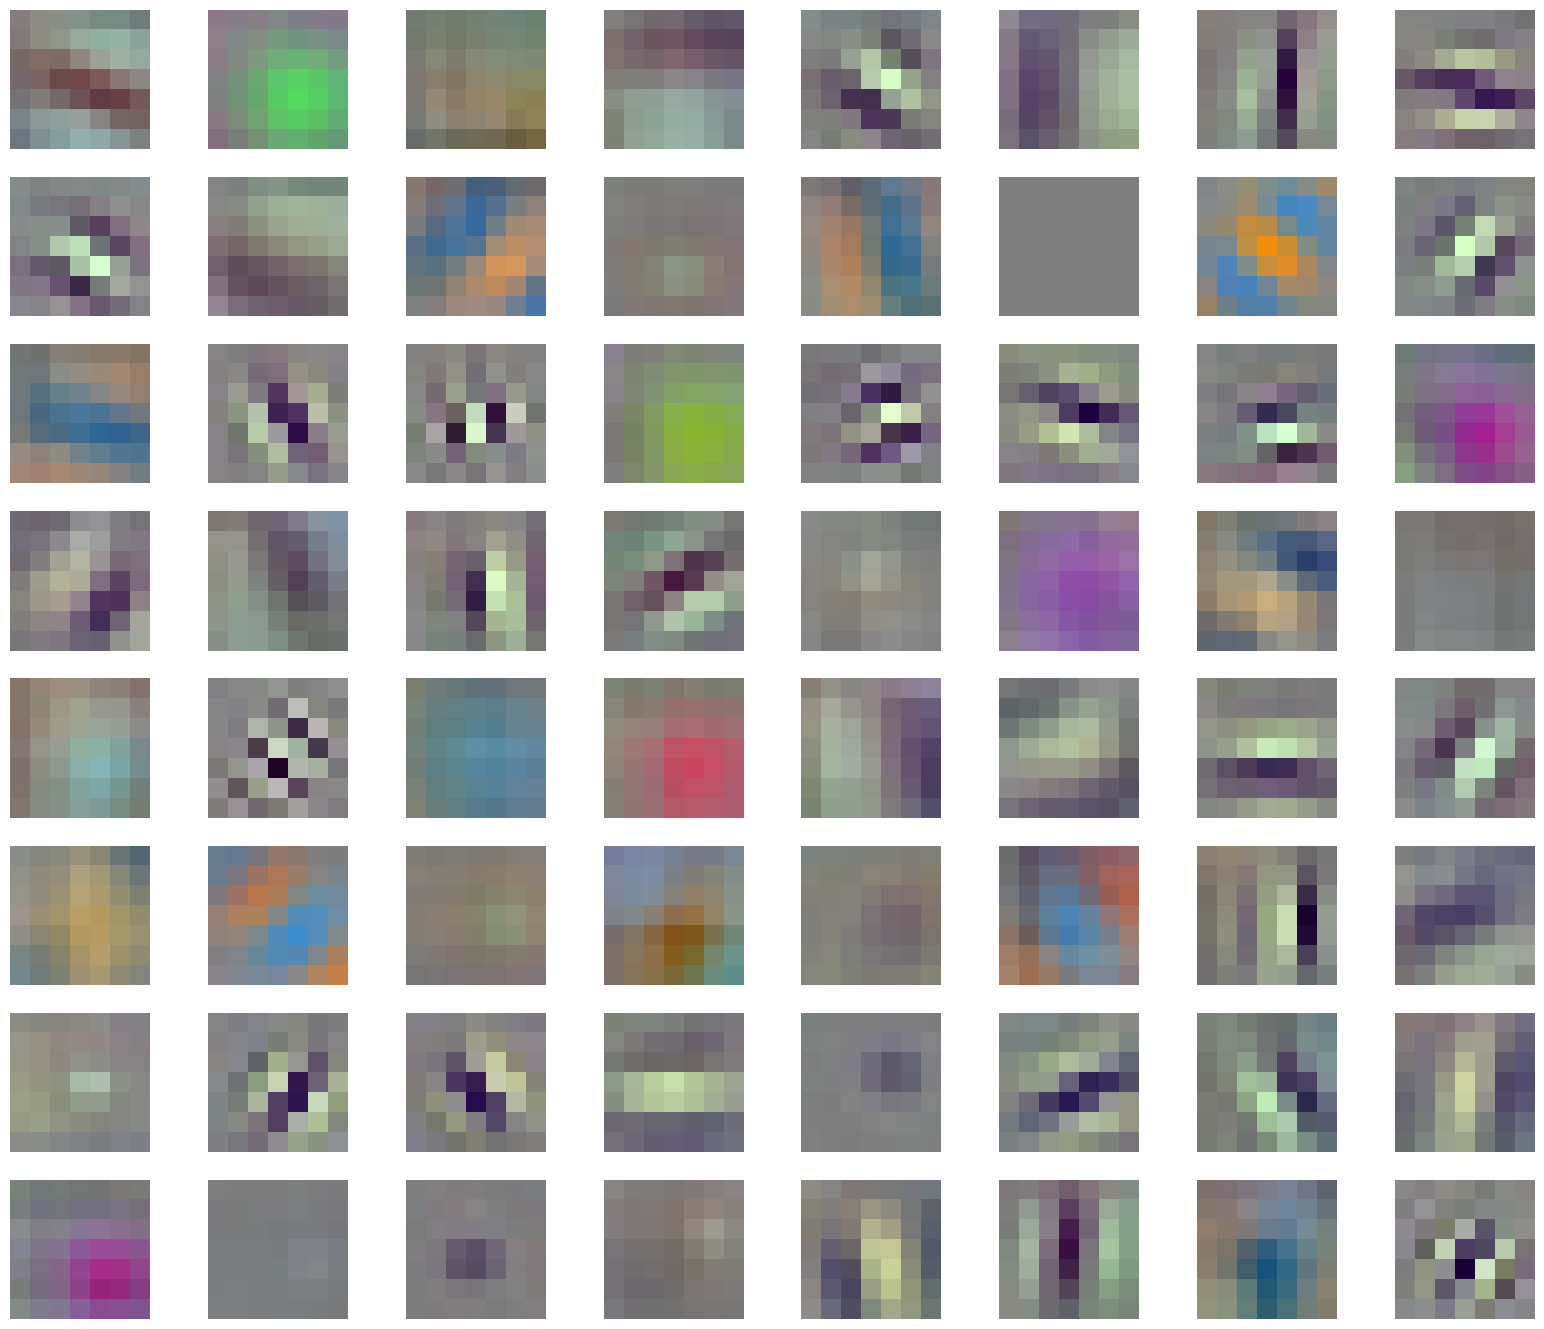

In [16]:
# Ensure it's in evaluation mode for visualization
model_res50.eval()  # This changes the model to evaluation mode

# Get the weights of the first convolutional layer
weights = model_res50.conv1.weight.data.cpu()

# Normalize the weights for better visualization
weights = (weights - weights.min()) / (weights.max() - weights.min())
print(weights[0])
print(weights[0].permute(1, 2, 0))
# Plot the first few filters
plt.figure(figsize=(20, 17))
for i in range(64):  # Let's visualize 64 filters
    plt.subplot(8, 8, i + 1)
    plt.imshow(weights[i].permute(1, 2, 0))  # Rearrange the dimensions
    plt.axis('off')
plt.show()

## Now, we switch model to eval mode and define a method to test on full sized testing images

In [ ]:
pedestrian_images_boxes = img_class_selector("pedestrian", forced_data_path=r"")

In [19]:
# window_size = 224
#Our test data/images will be preselected to only data that we know contains at least one instance of the target class.
#Additionally, we will only account for preexisting bounding boxes that are also of the target class. This simplifies the initial task, and can be expanded to include non-target class boxes for additional testing in the future.
#test_data will be of the form below which is a dictionaries with key as the img_id_name and the value as a list of 1:n dictionaries where each dictionary has two elements for the original and predicted bounding box whose
#values are simply the coordinates of the bounding box in image coordinates.
#Remember: All of our bounding_box_original boxes will be from the set of only the boxes of the target class.
#test_data = {img_id_name: [{bounding_box_original: np.array(), bounding_box_predicted: np.array()},
#                       {bounding_box_original: np.array(), bounding_box_predicted: np.array()}]}

# for img_id_name, box_list in test_data:
    #split up the image into "window_size" subsections. Input windows are 1024x1224, so window size of 224 will not split evenly. How to handle non-even splits for convolution/sliding windows?
    #for each subsection:
        #feed the subsection into my network and get a binary prediction: 1 - yes, this is the target class (pedestrain) or 0, no this is not the target class.

        #if we found a target class:
            #target_box = coordinates of the image that pertain to subsection that has a positive prediction
            

IndentationError: expected an indented block (1927823325.py, line 2)